In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image

#Remember to import "numpy_transforms" functions if you wish to import these two classes in a different script.

np.random.seed(0)

class CustomImageDataset:
    def __init__(self, root_dir, csv, transform=None):
        """
        Args:
            root_dir (string): Directory with all the subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(csv)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["Path"])
        image = Image.open(img_path).convert("L") #Convert image to greyscale
        label = row["class"]

        if self.transform:
            image = self.transform(image)

        return np.array(image), label

# Transformations using NumPy
def resize(image, size):
    # return np.array(Image.fromarray(image).resize(size))
    return np.array(image.resize(size))

def to_tensor(image):
    return image.astype(np.float32) / 255.0

def numpy_transform(image, size=(25, 25)):
    image = resize(image, size)
    image = to_tensor(image)
    image = image.flatten()
    return image

class DataLoader:
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = np.arange(len(dataset))
        # if self.shuffle:
        #     np.random.shuffle(self.indices)

    def __iter__(self):
        self.start_idx = 0
        return self
    def __len__(self):
        return int(len(self.dataset)/self.batch_size)

    def __next__(self):
        if self.start_idx >= len(self.dataset):
            raise StopIteration

        end_idx = min(self.start_idx + self.batch_size, len(self.dataset))
        batch_indices = self.indices[self.start_idx:end_idx]
        images = []
        labels = []

        for idx in batch_indices:
            image, label = self.dataset[idx]
            images.append(image)
            labels.append(label)

        self.start_idx = end_idx

        # Stack images and labels to create batch tensors
        batch_images = np.stack(images, axis=0)
        batch_labels = np.array(labels)

        return batch_images, batch_labels

In [10]:

# Root directory containing the 8 subfolders
root_dir = "./dataset_for_A2/multi_dataset"
mode = 'train' #Set mode to 'train' for loading the train set for training. Set mode to 'val' for testing your model after training. 

if mode == 'train': # Set mode to train when using the dataloader for training the model.
    csv = os.path.join(root_dir, "train.csv")

elif mode == 'val':
    csv = os.path.join(root_dir, "val.csv")

# Create the custom dataset
dataset = CustomImageDataset(root_dir=root_dir, csv = csv, transform=numpy_transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=256)

In [11]:
# Iterate through the DataLoader
for images, labels in dataloader:
    print(images.shape)  # Should be [batch_size, 625]
    print(labels.shape)  # Should be [batch_size]
    #Data being loaded!

(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(256, 625)
(256,)
(128, 625)
(128,)


In [12]:
def one_hot_encode(y, num_classes):
    # Convert y to a 2D one-hot encoding matrix
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

batches=[]
for images,labels in dataloader:
    one_hot_labels= one_hot_encode(labels,8)
    batches.append((images,one_hot_labels))

In [13]:
# import numpy as np
# import time

# # ReLU activation and its derivative
# def relu(x):
#     return np.maximum(0, x)

# def relu_derivative(x):
#     return np.where(x > 0, 1, 0)

# # Mean Squared Error loss
# def mean_squared_error(y_true, y_pred):
#     return np.mean(np.square(y_true - y_pred))

# # Neural Network Class with ReLU in the Output Layer and Hidden Layers
# class NeuralNetwork_Adam:
#     def __init__(self, input_size, hidden_sizes, output_size, init_weights=None, init_biases=None, init_seed=None, beta1=0.9, beta2=0.999, epsilon=1e-8):
#         if init_seed is None:
#             self.best_seed = int(time.time())
#             np.random.seed(self.best_seed)
#         else:
#             np.random.seed(init_seed)
#         self.weights = []
#         self.biases = []
#         self.m_w = []
#         self.v_w = []
#         self.m_b = []
#         self.v_b = []
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.epsilon = epsilon
#         self.t = 0  # Time step for Adam
#         self.best_weights = []
#         self.best_biases = []
#         self.best_loss = float("inf")

#         layer_sizes = [input_size] + hidden_sizes + [output_size]

#         # Initialize weights, biases, and Adam parameters (m, v)
#         for i in range(len(layer_sizes) - 1):
#             if (init_weights is not None) and (init_biases is not None):
#                 self.weights.append(init_weights[i])
#                 self.biases.append(init_biases[i])
#             else:
#                 self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]).astype(np.float64) * np.sqrt(2 / layer_sizes[i]))
#                 self.biases.append(np.zeros((1, layer_sizes[i + 1]), dtype=np.float64))
#             self.m_w.append(np.zeros_like(self.weights[-1]))
#             self.v_w.append(np.zeros_like(self.weights[-1]))
#             self.m_b.append(np.zeros_like(self.biases[-1]))
#             self.v_b.append(np.zeros_like(self.biases[-1]))
#             self.best_weights = self.weights
#             self.best_biases = self.biases

#     def forward(self, X):
#         activations = [X]
#         pre_activations = []

#         # Pass through each layer except the output layer
#         for i in range(len(self.weights) - 1):
#             z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
#             pre_activations.append(z)
#             a = relu(z)  # ReLU for hidden layers
#             activations.append(a)

#         # Pass through the output layer with ReLU
#         z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
#         pre_activations.append(z)
#         a = relu(z)  # ReLU for the output layer
#         activations.append(a)

#         return activations, pre_activations

#     def backward(self, X, y, activations, pre_activations):
#         grad_w = [np.zeros_like(w) for w in self.weights]
#         grad_b = [np.zeros_like(b) for b in self.biases]

#         # Start with output layer error
#         delta = activations[-1] - y
#         delta *= relu_derivative(pre_activations[-1])  # ReLU derivative for the output layer

#         for i in reversed(range(len(self.weights))):
#             grad_w[i] = np.dot(activations[i].T, delta) / delta.shape[0]
#             grad_b[i] = np.sum(delta, axis=0, keepdims=True) / delta.shape[0]

#             if i > 0:
#                 delta = np.dot(delta, self.weights[i].T) * relu_derivative(pre_activations[i - 1])

#         return grad_w, grad_b

#     def update_parameters(self, grad_w, grad_b, learning_rate):
#         self.t += 1  # Increment time step for Adam

#         for i in range(len(self.weights)):
#             # Update biased first moment estimate
#             self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grad_w[i]
#             self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grad_b[i]

#             # Update biased second moment estimate
#             self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grad_w[i] ** 2)
#             self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grad_b[i] ** 2)

#             # Compute bias-corrected first moment estimate
#             m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
#             m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)

#             # Compute bias-corrected second moment estimate
#             v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
#             v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

#             # Update weights and biases
#             self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
#             self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

#     def train(self, batches, time_of_running, learning_rate):
#         start_time = time.time()
#         epoch = 0
#         while True:
#             for X_batch, y_batch in batches:
#                 activations, pre_activations = self.forward(X_batch)
#                 grad_w, grad_b = self.backward(X_batch, y_batch, activations, pre_activations)
#                 self.update_parameters(grad_w, grad_b, learning_rate)

#             # Calculate average loss over batches
#             loss = 0
#             z = 0
#             for X_batch, y_batch in batches:
#                 y_pred, _ = self.forward(X_batch)
#                 loss += mean_squared_error(y_batch, y_pred[-1])
#                 z += len(y_pred[-1])
#             loss /= z
            
#             if loss < self.best_loss:
#                 self.best_loss = loss
#                 self.best_weights = self.weights
#                 self.best_biases = self.biases
#             print(f"Epoch {epoch + 1}, Loss: {loss:.10f}")
#             epoch += 1
#             # if time elapsed is greater than 1 minute, break the loop
#             if time.time() - start_time > 60 * time_of_running:
#                 break

#     def predict(self, X):
#         activations, _ = self.forward(X)
#         return activations[-1]

#     def get_best_weights(self):
#         return self.best_weights

#     def get_best_biases(self):
#         return self.best_biases

#     def get_best_loss(self):
#         return self.best_loss

#     def get_best_seed(self):
#         return self.best_seed


In [14]:
root_dir = "./dataset_for_A2/multi_dataset"
mode = 'val' #Set mode to 'train' for loading the train set for training. Set mode to 'val' for testing your model after training. 

if mode == 'train': # Set mode to train when using the dataloader for training the model.
    csv = os.path.join(root_dir, "train.csv")

elif mode == 'val':
    csv = os.path.join(root_dir, "val.csv")

# Create the custom dataset
dataset_val = CustomImageDataset(root_dir=root_dir, csv = csv, transform=numpy_transform)
# Create the DataLoader
dataloader_val = DataLoader(dataset_val, batch_size=len(dataset_val))

def one_hot_encode(y, num_classes):
    # Convert y to a 2D one-hot encoding matrix
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

batches_val=[]
for images,labels in dataloader_val:
    one_hot_labels= one_hot_encode(labels,8)
    batches_val.append((images,one_hot_labels))

accu=[]
def get_stat():
    for X_val, Y_val in batches_val:
        Y_pred= nn.predict(X_val)
        # print(cross_entropy_loss(Y_val,Y_pred)/len(dataset))
        z=accuracy(Y_val, Y_pred)
        accu.append(z)
        print(z)



In [15]:
import numpy as np
import time

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# Leaky ReLU activation and its derivative
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x, axis=None):
    exps = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exps / np.sum(exps, axis=axis, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)  # Avoid log(0)
    return -np.sum(np.sum(y_true * np.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Neural Network Class with Leaky ReLU and Adam Optimizer
class NeuralNetwork_Adam:
    def __init__(self, input_size, hidden_sizes, output_size, init_weights=None, init_biases=None, init_seed=None, alpha=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        if init_seed is None:
            self.best_seed = int(time.time())
            np.random.seed(self.best_seed)
        else:
            np.random.seed(init_seed)
        self.weights = []
        self.biases = []
        self.m_w = []
        self.v_w = []
        self.m_b = []
        self.v_b = []
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # Time step for Adam
        self.alpha = alpha  # Leaky ReLU parameter
        self.best_weights = []
        self.best_biases = []
        self.best_loss = float("inf")

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Initialize weights, biases, and Adam parameters (m, v)
        for i in range(len(layer_sizes) - 1):
            if init_weights is not None and init_biases is not None:
                self.weights.append(init_weights[i])
                self.biases.append(init_biases[i])
            else:
                self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]).astype(np.float64) * np.sqrt(2 / layer_sizes[i]))
                self.biases.append(np.zeros((1, layer_sizes[i + 1]), dtype=np.float64))
            self.m_w.append(np.zeros_like(self.weights[-1]))
            self.v_w.append(np.zeros_like(self.weights[-1]))
            self.m_b.append(np.zeros_like(self.biases[-1]))
            self.v_b.append(np.zeros_like(self.biases[-1]))
        # self.best_weights = self.weights
        # self.best_biases = self.biases

    def forward(self, X):
        activations = [X]
        pre_activations = []

        # Pass through each hidden layer
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            pre_activations.append(z)
            a = leaky_relu(z, alpha=self.alpha)  # Leaky ReLU for hidden layers
            # a = sigmoid(z)
            activations.append(a)

        # Pass through the output layer with softmax
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(z)
        a = softmax(z, axis=1)  # Softmax for the output layer
        activations.append(a)

        return activations, pre_activations

    def forward_pred(self, X):
        activations = [X]
        pre_activations = []

        # Pass through each hidden layer
        for i in range(len(self.best_weights) - 1):
            z = np.dot(activations[-1], self.best_weights[i]) + self.best_biases[i]
            pre_activations.append(z)
            a = leaky_relu(z, alpha=self.alpha)  # Leaky ReLU for hidden layers
            # a = sigmoid(z)
            activations.append(a)

        # Pass through the output layer with softmax
        z = np.dot(activations[-1], self.best_weights[-1]) + self.best_biases[-1]
        pre_activations.append(z)
        a = softmax(z, axis=1)  # Softmax for the output layer
        activations.append(a)

        return activations, pre_activations

    def backward(self, X, y, activations, pre_activations):
        grad_w = [np.zeros_like(w) for w in self.weights]
        grad_b = [np.zeros_like(b) for b in self.biases]

        # Start with output layer error
        delta = activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grad_w[i] = np.dot(activations[i].T, delta) / delta.shape[0]
            grad_b[i] = np.sum(delta, axis=0, keepdims=True) / delta.shape[0]

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * leaky_relu_derivative(pre_activations[i - 1], alpha=self.alpha)
                # delta = np.dot(delta, self.weights[i].T) * sigmoid_derivative(pre_activations[i - 1])

        return grad_w, grad_b

    def update_parameters(self, grad_w, grad_b, learning_rate):
        self.t += 1  # Increment time step for Adam

        for i in range(len(self.weights)):
            # Update biased first moment estimate
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grad_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grad_b[i]

            # Update biased second moment estimate
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grad_w[i] ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grad_b[i] ** 2)

            # Compute bias-corrected first moment estimate
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)

            # Compute bias-corrected second moment estimate
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

            # Update weights and biases
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, batches, time_of_running, learning_rate):
        start_time = time.time()
        epoch = 0
        while True:
            for X_batch, y_batch in batches:
                activations, pre_activations = self.forward(X_batch)
                grad_w, grad_b = self.backward(X_batch, y_batch, activations, pre_activations)
                self.update_parameters(grad_w, grad_b, learning_rate)

            # Calculate average loss over batches
            loss = 0
            z = 0
            for X_batch, y_batch in batches:
                y_pred, _ = self.forward(X_batch)
                loss += cross_entropy_loss(y_batch, y_pred[-1])
                z += len(y_pred[-1])
            loss /= z
            
            if loss < self.best_loss:
                self.best_loss = loss
                self.best_weights = [np.copy(w) for w in self.weights]  # Use np.copy to create independent copies
                self.best_biases = [np.copy(b) for b in self.biases]  # Use np.copy for biases
            print(f"Epoch {epoch + 1}, Loss: {loss:.10f}")
            get_stat()
            epoch += 1
            # if time elapsed is greater than 1 minute, break the loop
            if time.time() - start_time > 60 * time_of_running:
                break

    def predict(self, X):
        activations, _ = self.forward_pred(X)
        return activations[-1]
    
    def get_best_weights(self):
        return self.best_weights
    
    def get_best_biases(self):
        return self.best_biases
    
    def get_best_loss(self):
        return self.best_loss
    
    def get_best_seed(self):
        return self.best_seed

# Example usage:
# nn = NeuralNetwork_Adam(625, [512, 256, 128, 32], 8)
# nn.train(batches, 1, 0.001)


In [16]:
# Root directory containing the 8 subfolders
root_dir = "./dataset_for_A2/multi_dataset"
mode = 'train' #Set mode to 'train' for loading the train set for training. Set mode to 'val' for testing your model after training. 

if mode == 'train': # Set mode to train when using the dataloader for training the model.
    csv = os.path.join(root_dir, "train.csv")

elif mode == 'val':
    csv = os.path.join(root_dir, "val.csv")

# Create the custom dataset
dataset = CustomImageDataset(root_dir=root_dir, csv = csv, transform=numpy_transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=256)

def one_hot_encode(y, num_classes):
    # Convert y to a 2D one-hot encoding matrix
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

batches=[]
for images,labels in dataloader:
    one_hot_labels= one_hot_encode(labels,8)
    batches.append((images,one_hot_labels))

best_loss = float('inf')
best_weights_init = []
best_biases_init = []
best_weights = []
best_biases = []
best_seed = 0

for _ in range (1):
    nn = NeuralNetwork_Adam(625, [256,128,64], 8, beta1=0.95, beta2=0.999)
    nn.train(batches,14,learning_rate=0.0015)
    if nn.get_best_loss() < best_loss:
        best_loss = nn.get_best_loss()
        best_weights = nn.get_best_weights()
        best_biases = nn.get_best_biases()
        best_seed = nn.get_best_seed()

print(best_loss)

Epoch 1, Loss: 2.1609061625
0.12625
Epoch 2, Loss: 2.1285123255
0.125
Epoch 3, Loss: 2.0867514542
0.17875
Epoch 4, Loss: 2.0593951172
0.125
Epoch 5, Loss: 2.0398176002
0.12625
Epoch 6, Loss: 2.0249242763
0.21125
Epoch 7, Loss: 2.0227918921
0.24125
Epoch 8, Loss: 2.0206058696
0.19625
Epoch 9, Loss: 1.9689863800
0.23625
Epoch 10, Loss: 1.9335954007
0.23875
Epoch 11, Loss: 1.8739352765
0.38375
Epoch 12, Loss: 1.8225156874
0.2975
Epoch 13, Loss: 1.7803616662
0.2725
Epoch 14, Loss: 1.7174082559
0.29125
Epoch 15, Loss: 1.7134289399
0.34875
Epoch 16, Loss: 1.6339820140
0.39
Epoch 17, Loss: 1.6041188120
0.45125
Epoch 18, Loss: 1.6012307639
0.3875
Epoch 19, Loss: 1.5653306189
0.42
Epoch 20, Loss: 1.5466052700
0.43
Epoch 21, Loss: 1.5281205680
0.41375
Epoch 22, Loss: 1.5200007172
0.39875
Epoch 23, Loss: 1.4736901671
0.4425
Epoch 24, Loss: 1.4464599568
0.43875
Epoch 25, Loss: 1.4202859503
0.45375
Epoch 26, Loss: 1.3826374651
0.4825
Epoch 27, Loss: 1.3905137525
0.4825
Epoch 28, Loss: 1.3481045328


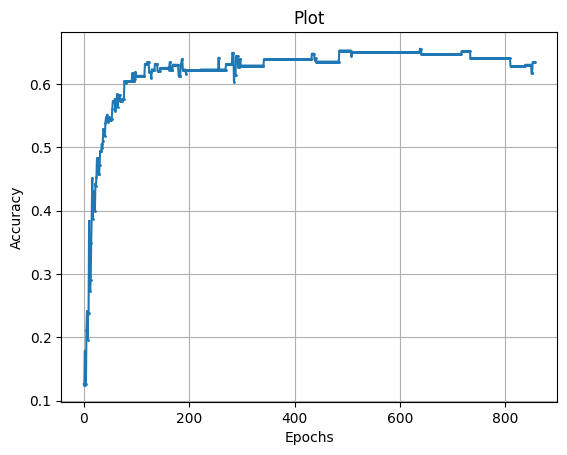

In [29]:
import numpy as np
import matplotlib.pyplot as plt


x = range(len(accu))

# Plot the array
plt.plot(x, accu, marker='o',markersize=1)  # 'o' adds markers at each data point

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot')

# Show grid
plt.grid()

# Display the plot
plt.show()


In [18]:
print(best_loss)
# print(best_seed)

0.11745977230775956


In [19]:
# nn = NeuralNetwork_Adam(625, [512, 256, 128, 32], 8, init_weights=best_weights, init_biases=best_biases, init_seed=best_seed)
# nn.train(batches, 3, 0.001)

In [20]:
# print(nn.get_best_loss())

In [21]:
import pickle

# Number of layers in the Neural Network
N = 4  # Example value, replace with the actual number of layers

# Initialize the dictionary
weights_dict = {
    'weights': {},
    'bias': {}
}

weights = nn.get_best_weights()
biases = nn.get_best_biases()

# Populate the weights and bias dictionaries
for i in range(N):
    weights_dict['weights'][f'fc{i+1}'] = weights[i]
    weights_dict['bias'][f'fc{i+1}'] = biases[i].flatten()

# Save the dictionary as a pickle file
with open('weights.pkl', 'wb') as f:
    pickle.dump(weights_dict, f)

In [22]:
root_dir = "./dataset_for_A2/multi_dataset"
mode = 'val' #Set mode to 'train' for loading the train set for training. Set mode to 'val' for testing your model after training. 

if mode == 'train': # Set mode to train when using the dataloader for training the model.
    csv = os.path.join(root_dir, "train.csv")

elif mode == 'val':
    csv = os.path.join(root_dir, "val.csv")

# Create the custom dataset
dataset = CustomImageDataset(root_dir=root_dir, csv = csv, transform=numpy_transform)
# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=len(dataset))

def one_hot_encode(y, num_classes):
    # Convert y to a 2D one-hot encoding matrix
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

batches=[]
for images,labels in dataloader:
    one_hot_labels= one_hot_encode(labels,8)
    batches.append((images,one_hot_labels))

for X_val, Y_val in batches:
    Y_pred= nn.predict(X_val)
    print(cross_entropy_loss(Y_val,Y_pred)/len(dataset))
    print(accuracy(Y_val, Y_pred))

1.9331559330982713
0.63375
